## Digit Recognizer
This time I am going to continue with the kaggle 101 level competition - [digit recogniser](https://www.kaggle.com/c/digit-recognizer) with deep learning tool Tensor Flow.

### 0. Previously
In the [previous post](https://github.com/6chaoran/DataStory/tree/master/kaggle-digits), I used PCA and Pooling methods to reduce the dimensions of the dataset, and train with the linear SVM. Due to the limited efficiency of the R SVM package. I only sampled 500 records and performed a 10-fold cross validation. The resulting accuracy is about 82.7%

### 1. This Time
With new tool TensorFlow, we can address the problem differently:
* __Deep Learning__, especially Convolutional Neural Network is well suitable for image recognition problem.
* __TensorFlow__ is a good tool to equickly build the neural network architecture and also empowers the capability of GPUs.
* __Convolution Layers__ artificially create additional features
* __Stochastic Gradient Descent__ replaces Gradient Descent. SGD takes sample of data to update the gradients, making training fast and less RAM consumption. 

Fully utilized the entire dataset (42k records) with deep learning models, the accuracy easily go up above 95%.

### 2. Load Data
data was prepared using pandas, and saved as numpy array

In [1]:
## load releveant packages
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = np.load('train_data.npy')
Y = data[:,0].astype(np.int8)
X = data[:,1:].astype(np.float32)

### 3. Visualize Image

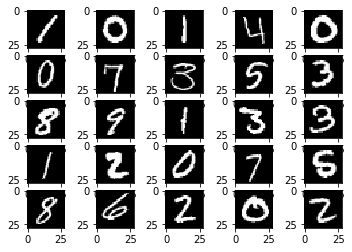

In [3]:
n = 5
fig, subs = plt.subplots(n,n)
k = 0
for i in range(n):
    for j in range(n):
        subs[i,j].imshow(X[k].reshape(28,28), cmap = 'gray')
        k+=1

### Split Data Into Train/Validation
split 70% train set and 30% validation set

In [4]:
n,dim = X.shape
index = np.arange(n)
np.random.shuffle(index)
cut = int(0.7*n)
inTrain = index[:cut]
inVal = index[cut:]

X_train = X[inTrain,:]
Y_train = Y[inTrain]
X_val = X[inVal,:]
Y_val = Y[inVal]

### 4. Deep Neural Network - DNN
Deep Neural Network consists of input layer, mulitple hidden layers and output layer.
* __Input Layer__, denoted as X, is the data with full dimension
* __Hidden Layer__, is the layer affined from input layer (in multiple times) by the weight w and bias b. The affined score is then denoted as wX+b. The scored need to be activated through a activation function. ReLU (rectified linear unit) is used in here.
* __Output Layer__, is affined score from the last hidden layer, and the score will finally map to prediction output.

In this exmpale, I'm going to build a two layer DNN:

* input layer: take full dimension of 784 (28*28)
* hidden layer: affine dimension 784 to 256
* output layer: affine dimension 256 to 10

In [5]:
def init_weight(shape):
    return tf.Variable(tf.truncated_normal(dtype=tf.float32, shape = shape, stddev=1e-4), dtype = tf.float32)

def init_bias(shape):
    return tf.Variable(tf.zeros(shape),dtype=tf.float32)

In [6]:
def DNN(x,y,reg,keep_prob,Dropout = False):

    ## define weight and bias
    Wfc1 = init_weight([784,256])
    Bfc1 = init_bias([256])
    Wfc2 = init_weight([256,10])
    Bfc2 = init_bias([10])

    ## define two layer nn:
    a1 = tf.matmul(x,Wfc1)+Bfc1  # fully-connected layer1
    a2 = tf.nn.relu(a1)  # ReLU activation layer
    logits = tf.matmul(a2,Wfc2)+Bfc2  # fully-connnected layer2
    
    ## forward step: get softmax loss and L2 regularized loss
    total_loss = tf.losses.sparse_softmax_cross_entropy(labels=y,logits=logits)
    mean_loss = tf.reduce_mean(total_loss)
    reg_loss = tf.reduce_mean(tf.square(Wfc1)) + tf.reduce_mean(tf.square(Wfc2))
    loss = mean_loss + reg * reg_loss
    
    ## get accuracy
    y_ = tf.cast(tf.argmax(logits,axis=1), tf.int32)
    acc = tf.reduce_mean(tf.cast(tf.equal(y_,y),tf.float32))
    return loss, acc

### 5. Convolutional Neural Network - CNN
Additionally introduce __Convolutional_layer__ and __Pool_layer__ to tackle the image problem
In this simple CNN:
* conv layer: 32 5x5x1 filters
* pool layer: 2x2 max pool
* relu layer
* densely connectd layer: affined to 1024 dimension
* relu layer
* readout layer: affined to 10 classes

In [15]:
def conv2d(X,W):
    return tf.nn.conv2d(X,W,strides=[1,2,2,1],padding='SAME')

def max_pool_2x2(X):
    return tf.nn.max_pool(X,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')

In [8]:
## define a CNN
def CNN(x,y,reg,keep_prob,Dropout = False):
    
    x_fold = tf.reshape(x,[-1,28,28,1])
    
    ## init filters
    Wconv1 = init_weight([5,5,1,32])
    Bconv1 = init_bias([32])

    ## init weight and bias
    Wfc1 = init_weight([7*7*32,1024])
    Bfc1 = init_bias([1024])
    Wfc2 = init_weight([1024,10])
    Bfc2 = init_bias([10])

    ## two layer nn
    a1 = (conv2d(x_fold,Wconv1)+Bconv1) #conv1
    a2 = tf.nn.relu(max_pool_2x2(a1)) #maxpool1
    if Dropout:
        dropout = tf.reshape(tf.nn.dropout(a2, keep_prob=keep_prob),[-1,7*7*32])
    else:
        dropout = tf.reshape(a2,[-1,7*7*32])
    a3 = tf.matmul(dropout,Wfc1)+Bfc1 #full-connected 1
    logits = tf.matmul(a3,Wfc2)+Bfc2 # fully-connected 2
    
    ## get loss
    total_loss = tf.losses.sparse_softmax_cross_entropy(labels=y,logits=logits)
    mean_loss = tf.reduce_mean(total_loss)
    reg_loss = tf.reduce_mean(tf.square(Wfc1)) + tf.reduce_mean(tf.square(Wfc2))
    loss = mean_loss + reg * reg_loss
    
    ##  get accuracy
    y_ = tf.cast(tf.argmax(logits,axis=1), tf.int32)
    acc = tf.reduce_mean(tf.cast(tf.equal(y_,y),tf.float32))
    return loss, acc

### 6. Deeper CNN
Go deeper with the CNN:

* conv layer: 32 5x5x1 filters
* pool layer: 2x2 max pool
* relu layer
* conv layer: 64 5x5x1 filters
* pool layer: 2x2 max pool
* relu layer
* densely connectd layer: affined to 1024 dimension
* relu layer
* readout layer: affined to 10 classes


In [9]:
def deep_CNN(x,y,reg,keep_prob,Dropout = False):
    
    x_fold = tf.reshape(x,[-1,28,28,1])
    
    ## init filters
    Wconv1 = init_weight([5,5,1,32])
    Bconv1 = init_bias([32])
    Wconv2 = init_weight([5,5,32,64])
    Bconv2 = init_bias([64])

    ## init weight and bias
    Wfc1 = init_weight([2*2*64,1024])
    Bfc1 = init_bias([1024])
    Wfc2 = init_weight([1024,10])
    Bfc2 = init_bias([10])

    ## two layer nn
    a1 = (conv2d(x_fold,Wconv1)+Bconv1) #conv1
    a2 = tf.nn.relu(max_pool_2x2(a1)) #maxpool1
    a3 = (conv2d(a2,Wconv2)+Bconv2) #conv1
    a4 = tf.nn.relu(max_pool_2x2(a3)) #maxpool1
    a5 = tf.reshape(a4,[-1,2*2*64])
    if Dropout:
        dropout = tf.nn.dropout(a5,keep_prob)
    else:
        dropout = a5
    a6 = tf.nn.relu(tf.matmul(dropout,Wfc1)+Bfc1) #full-connected 1
    logits = tf.matmul(a6,Wfc2)+Bfc2 # fully-connected 2
    
    ## get loss
    total_loss = tf.losses.sparse_softmax_cross_entropy(labels=y,logits=logits)
    mean_loss = tf.reduce_mean(total_loss)
    reg_loss = tf.reduce_mean(tf.square(Wfc1)) + tf.reduce_mean(tf.square(Wfc2))
    loss = mean_loss + reg * reg_loss
    
    ##  get accuracy
    y_ = tf.cast(tf.argmax(logits,axis=1), tf.int32)
    acc = tf.reduce_mean(tf.cast(tf.equal(y_,y),tf.float32))
    return loss, acc

### 7. Evaluate Different Models
* DNN is fast and gives ~95.7% accuracy.
* CNN is much slower due to proccessing of convolutional layers. Accuary is then improved to 96.2% and 98% for CNN and deeper CNN respectively.

In [10]:
def run_model(model,X_train,Y_train,X_val,Y_val,lr = 1e-3,reg = 0.3,dropout = False,keep_prob = 0.5,maxIter = 200,batchSize = 128):
    
    n,_ = X_train.shape # get train size 
    
    ## define placeholder (containers) 
    ## for features - x, label - y, regularization - reg
    x = tf.placeholder(dtype=tf.float32, shape=[None,784]) 
    y = tf.placeholder(dtype = tf.int32, shape= [None])
    keepProb = tf.placeholder(dtype=tf.float32)
    
    ## get loss, accuracy from specific model
    loss, acc = model(x,y,reg,keepProb,dropout)
    ## used AdamOptimizer(GradientDesenct Alternative)
    optimizer = tf.train.AdamOptimizer(lr) 
    train_step = optimizer.minimize(loss) # objective - minimize loss function
    
    ## populate loss/accuarcy history for plotting
    lossHistory = []
    accHistory = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        print ('Training')
        
        ## stochastic training with batchSize 128
        for i in range(maxIter):
            inTrain = np.random.choice(n,batchSize)
            batchX = X_train[inTrain,:]
            batchY = Y_train[inTrain]
            train_step.run(feed_dict={x:batchX,y:batchY,keepProb:keep_prob},session=sess)
            
            iterLoss = loss.eval(feed_dict={x:batchX,y:batchY,keepProb:1.0},session=sess)
            iterAcc = acc.eval(feed_dict={x:batchX,y:batchY,keepProb:1.0},session=sess)
            lossHistory.append(iterLoss)
            accHistory.append(iterAcc)
            if i%100 ==0:
                print ('iter {0:2d}: loss {1:.3f} acc {2:.3f}').format(i,iterLoss, iterAcc)

        print('Validation')
        iterLoss = loss.eval(feed_dict={x:X_val,y:Y_val,keepProb:1.0},session=sess)
        iterAcc = acc.eval(feed_dict={x:X_val,y:Y_val,keepProb:1.0},session=sess)
        print('loss {0:.3f} acc {1:.3f}').format(iterLoss, iterAcc)
        
        fig, (lossPlot,accPlot) = plt.subplots(1,2)
        accPlot.plot(accHistory[1:], 'go-', label='accuracy', linewidth=2)
        accPlot.set_title("Batch Accuracy")
        lossPlot.plot(lossHistory[1:], 'bo-', label='loss', linewidth=2)
        lossPlot.set_title("Batch Loss")

Training
iter  0: loss 2.190 acc 0.273
iter 100: loss 0.131 acc 0.945
iter 200: loss 0.059 acc 0.977
iter 300: loss 0.037 acc 0.984
iter 400: loss 0.038 acc 0.984
iter 500: loss 0.062 acc 0.969
iter 600: loss 0.073 acc 0.977
iter 700: loss 0.078 acc 0.984
iter 800: loss 0.075 acc 0.977
iter 900: loss 0.093 acc 0.977
Validation
loss 0.180 acc 0.957
CPU times: user 54.7 s, sys: 3.86 s, total: 58.6 s
Wall time: 20.2 s


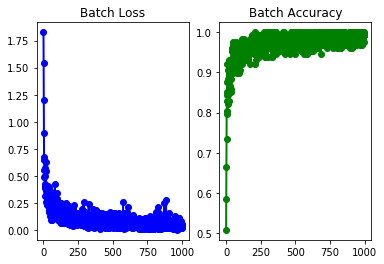

In [11]:
%time run_model(DNN, X_train, Y_train, X_val, Y_val,maxIter=1000)

Training
iter  0: loss 2.299 acc 0.227
iter 100: loss 0.111 acc 0.984
iter 200: loss 0.063 acc 0.984
iter 300: loss 0.168 acc 0.953
iter 400: loss 0.012 acc 1.000
iter 500: loss 0.049 acc 0.984
iter 600: loss 0.047 acc 0.992
iter 700: loss 0.070 acc 0.984
iter 800: loss 0.072 acc 0.984
iter 900: loss 0.040 acc 0.992
Validation
loss 0.145 acc 0.965
CPU times: user 8min 19s, sys: 26.3 s, total: 8min 46s
Wall time: 2min 37s


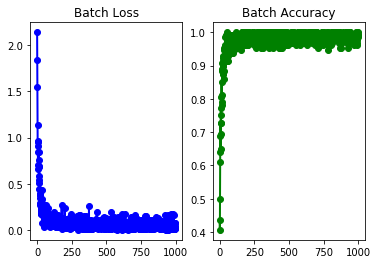

In [12]:
%time run_model(CNN, X_train, Y_train, X_val, Y_val,maxIter=1000)

Training
iter  0: loss 2.302 acc 0.133
iter 100: loss 0.249 acc 0.922
iter 200: loss 0.187 acc 0.953
iter 300: loss 0.096 acc 0.969
iter 400: loss 0.073 acc 0.977
iter 500: loss 0.023 acc 0.992
iter 600: loss 0.033 acc 0.984
iter 700: loss 0.033 acc 0.984
iter 800: loss 0.017 acc 0.992
iter 900: loss 0.010 acc 1.000
Validation
loss 0.070 acc 0.980
CPU times: user 5min 42s, sys: 34 s, total: 6min 16s
Wall time: 2min 8s


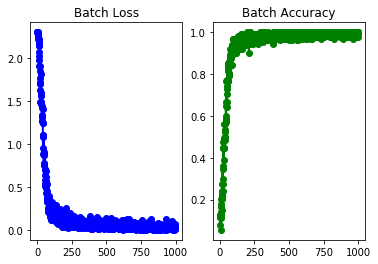

In [13]:
%time run_model(deep_CNN, X_train, Y_train, X_val, Y_val,maxIter=1000)